# Transfer Learning

[전이학습이해](https://www.notion.so/mongmang/Transfer-Learning-a5f7e7162c3d4ba1988f835f751a98ae)

#### TensorFlow 패키지 

In [2]:
#!pip install --upgrade tensorflow
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.5.0
Keras version: 2.5.0


In [3]:
# GPU 확인하기
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1590459455608887056]

## Prepare the base model

전이학습을 위해 특징 추출 레이어를 사용할 수 있는 훈련된 기본 모델이 필요  

**ResNet model**
* ImageNet 1000개의 클래스 이미지들을 사전 학습한 CNN 기반 이미지 분류 모델
* residual(=conv +bn+relu) layer를 50개 쌓은 모델로 깊은 신경망 모델



In [5]:
# base 모델 불러오기
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print(base_model.summary())

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

## 이미지데이터 불러오기 및 전처리 

* 사전에 학습된 base model을 활용하여 학습시키려면 이전에 훈련시킬때 사용한 이미지 데이터와 동일한 크기와 형태(pixel values)로 전처리가 필요하다.  ->224x224 pixels로 전처리 진행함 

* ImageDataGenerator에서 ResNet 모델을 학습하는데 사용된 형식과 일치하도록 입력 이미지의 픽셀 값을 정규화 합니다

*  7:3으로 학습 및 검증 데이터셋으로 나누어서 각 데이터셋의 크기를 맞추고 배치크기만큼 불러올 수 있도록 Data Generator에 지정합니다.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = 'data/shapes'
pretrained_size = (224,224) # pixel values
batch_size = 30

# ImageDataGenerator 객체 -> normalizaion, validation_split
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) 

# Train set 가져오기
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize 진행 
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

# validation dataset 가져오기
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize 
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

# 타겟 클래스 값 가져오기
classnames = list(train_generator.class_indices.keys())

print("class names: ", classnames)


Found 840 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
class names:  ['circle', 'square', 'triangle']


## Create a prediction layer

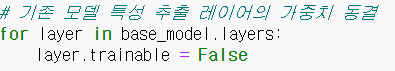
`layer.trainable = False`로 설정
* 기존 모델 특성 추출 레이어의 가중치를 동결
* 최종 예측 레이어를 사용할 데이터셋의 클래스 개수만큼 예측할 수 있도록 Dense layer 추가
* 최종 예측 레이어의 가중치만 학습되고 최적화 

In [7]:
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense

# 기존 모델 특성 추출 레이어의 가중치 동결
for layer in base_model.layers:
    layer.trainable = False

# prediction layer 생성 
x = base_model.output # base model 가져옴
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) # 예측 클래스 수 지정(output)

# 전이 학습 모델 생성
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Dense layer 추가한 모델
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Train the Model

With the layers of the CNN defined, we're ready to train it using our image data. The weights used in the feature extraction layers from the base resnet model will not be changed by training, only the final dense layer that maps the features to our shape classes will be trained.

In [8]:
# Train the model
num_epochs = 3
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/3
28/28 [==============================] - 66s 2s/step - loss: 2.0471 - accuracy: 0.5536 - val_loss: 0.9082 - val_accuracy: 0.5056
Epoch 2/3
28/28 [==============================] - 64s 2s/step - loss: 0.3049 - accuracy: 0.8917 - val_loss: 0.2369 - val_accuracy: 0.8972
Epoch 3/3
28/28 [==============================] - 63s 2s/step - loss: 0.1786 - accuracy: 0.9357 - val_loss: 0.1283 - val_accuracy: 0.9750


## loss function 시각화

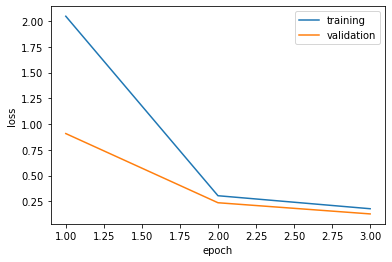

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 모델 성능 평가

분류모델 --> confusion matrix 

Generating predictions from validation data...


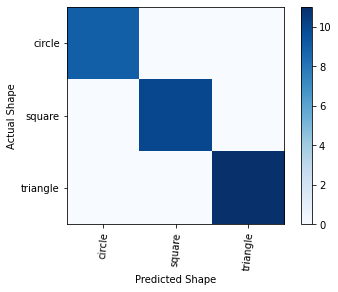

In [19]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Inference 모델 추론

triangle


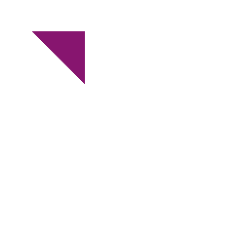

In [15]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((224,224), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
class_idx = predict_image(model, img)
print (classnames[class_idx])